In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the CSV file to verify it
df_sentences = pd.read_csv('../datasets/ilikecats.csv')

# Display the first few entries
print(df_sentences.head())

# Filter the DataFrame for rows where the Label column is 'Animal'
animal_sentences = df_sentences[df_sentences['Label'] == 'Animal']['Sentence'].tolist()
non_animal_sentences = df_sentences[df_sentences['Label'] == 'Non-Animal']['Sentence'].tolist()


    Label           Sentence
0  Animal       I like cats.
1  Animal       I like dogs.
2  Animal  I like elephants.
3  Animal     I like tigers.
4  Animal      I like birds.


In [3]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token



In [4]:
# Initialize the tokenizer and model #huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")



Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


In [5]:

# Check if CUDA is available and set the model to use GPU
print('cuda') if t.cuda.is_available() else print("cpu")
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)
t.cuda.empty_cache()  # Clear unused memory
_ = model.eval()

cuda


Using device: cuda


In [6]:
# Set the EOS token as the padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [7]:
# Global container to store activations 
activations = {}

def get_activation(name):
    # closure to store activation
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

# Attaching hooks to each layer of the model
for i, layer in enumerate(model.model.layers):
    layer.register_forward_hook(get_activation(f'Decoder_Layer_{i}'))


In [8]:
# Print max number of layers and max number of tokens
print(f"Number of layers = {len(model.model.layers)}")
max_tokens = tokenizer(df_sentences['Sentence'].tolist(), return_tensors="pt", padding=True, truncation=True)['input_ids'].shape[-1]
print(f"Number of tokens = {max_tokens}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Number of layers = 32
Number of tokens = 13


In [10]:
t.cuda.empty_cache()  # Clear unused memory

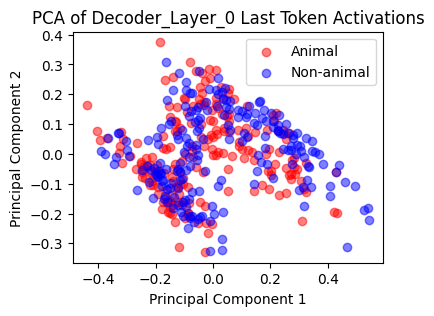

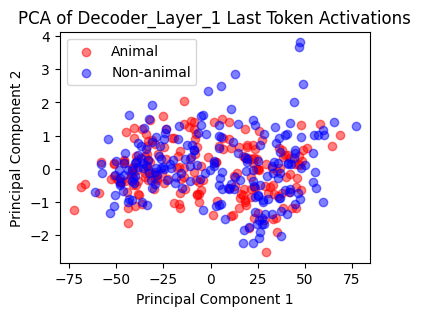

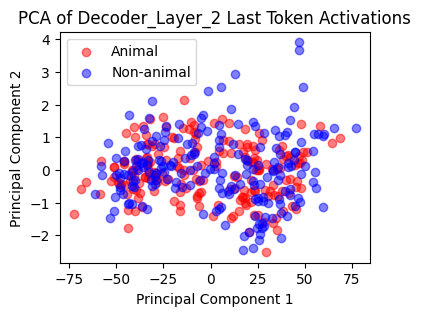

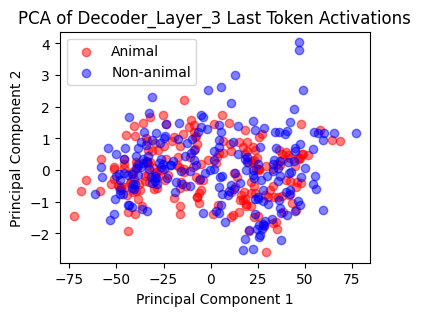

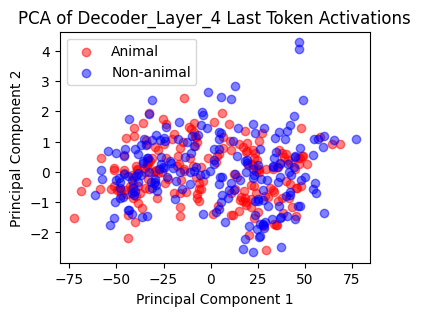

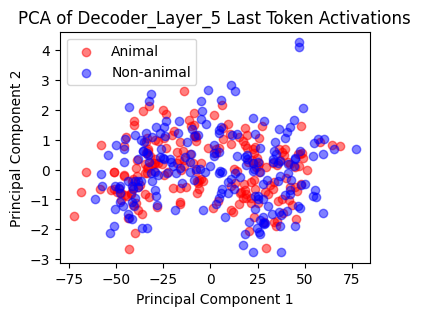

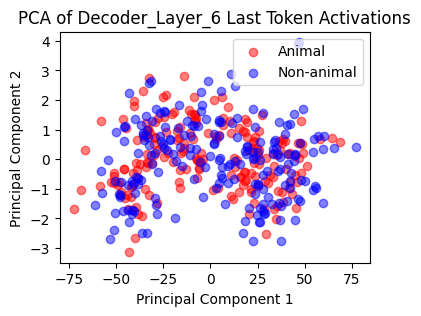

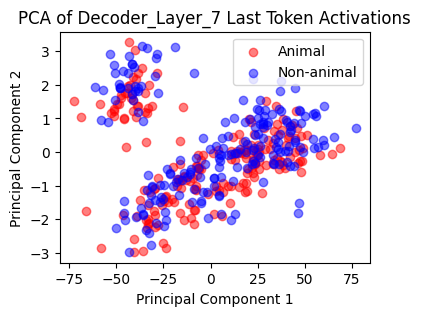

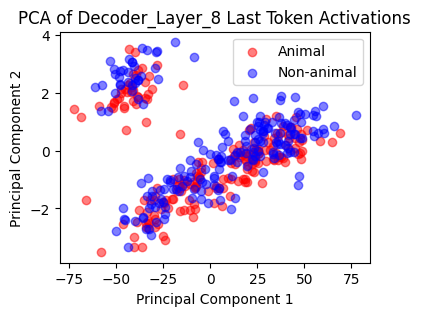

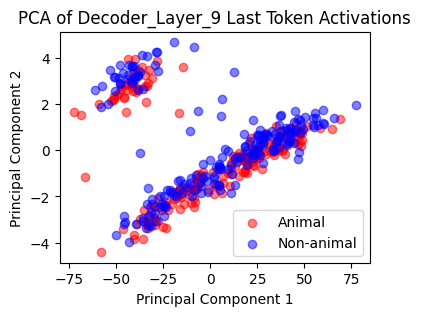

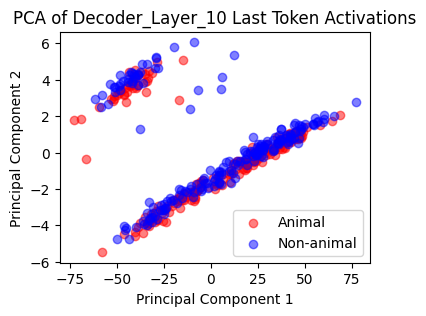

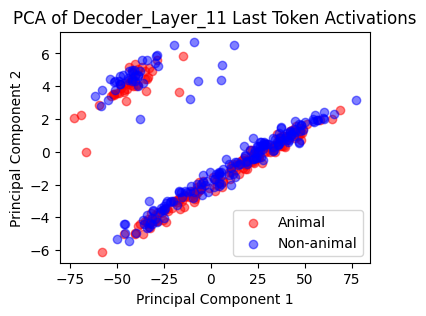

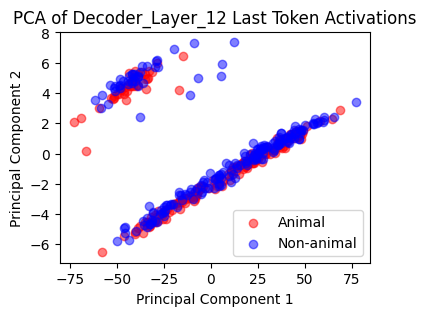

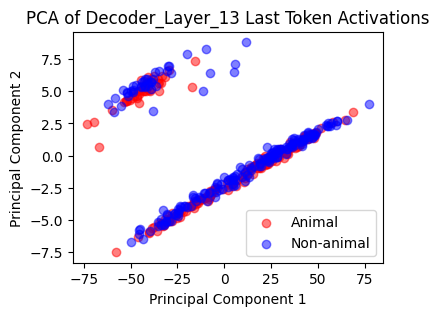

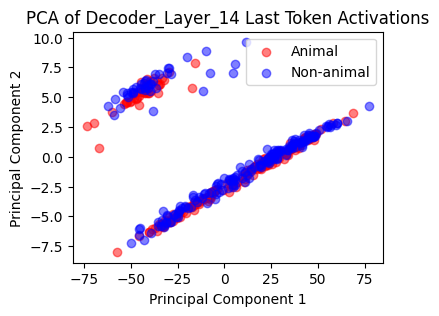

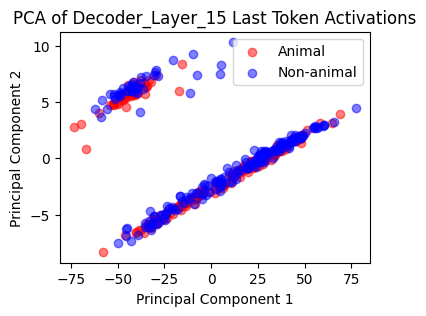

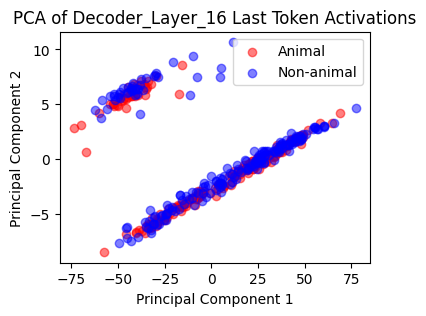

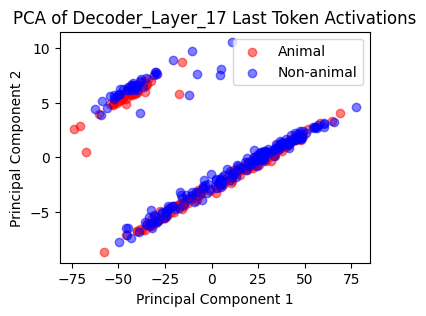

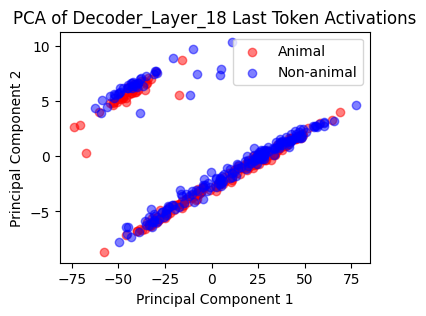

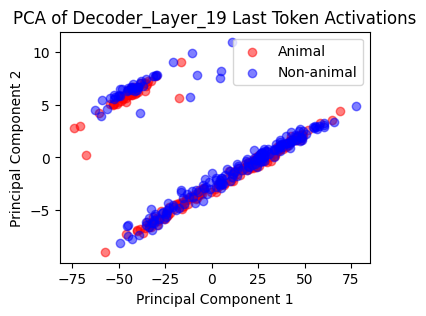

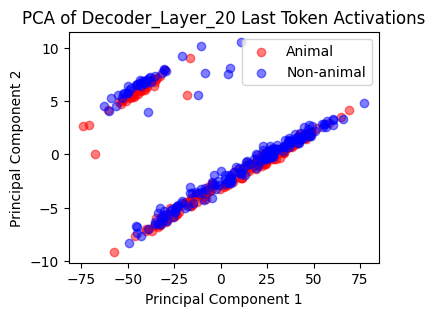

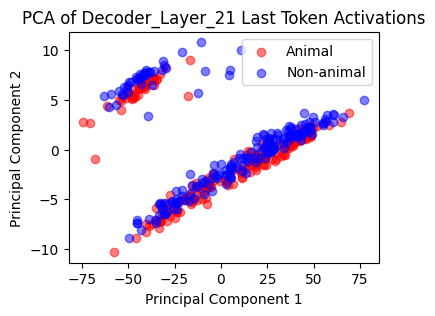

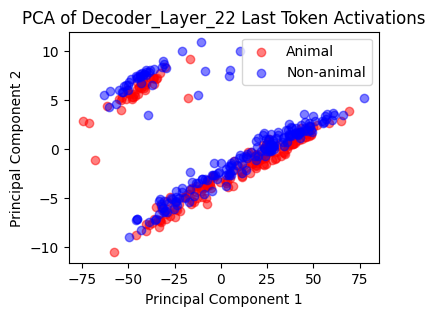

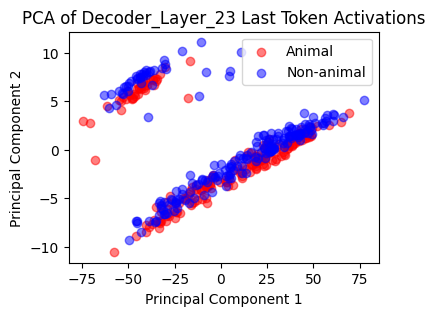

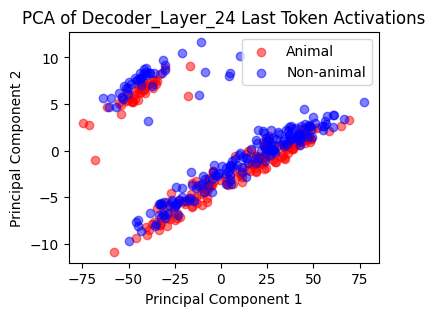

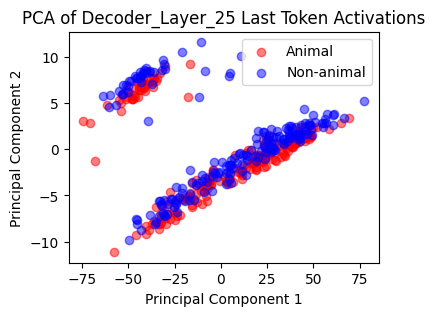

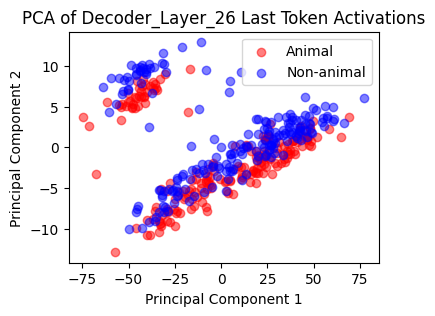

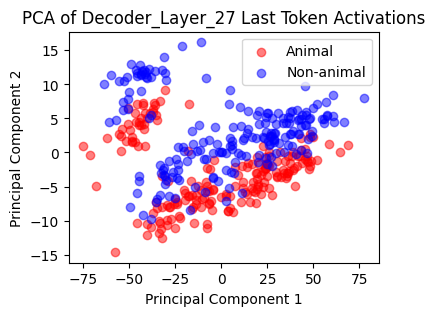

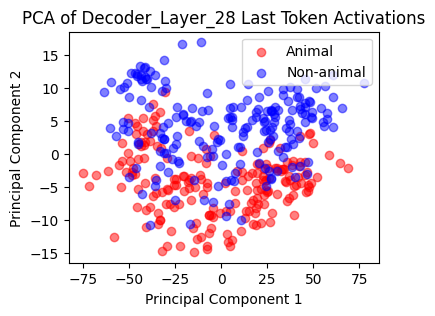

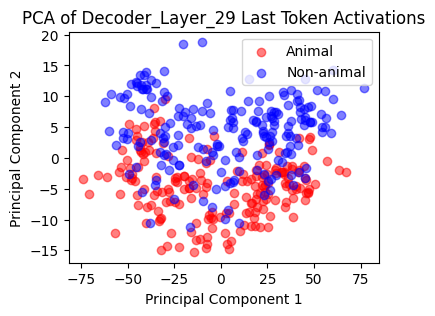

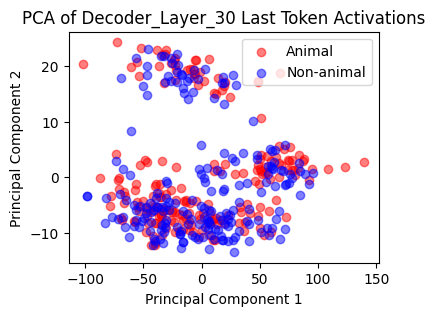

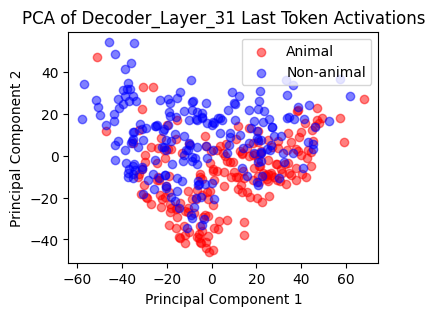

In [13]:

num_samples = 200
layer_names = ['Decoder_Layer_{}'.format(i) for i in range(32)]  # All layers

# Shuffle sentences
random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

# Function to process sentences and extract activations for the last token
def process_sentences(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
    inputs = {key: val.to('cuda') for key, val in inputs.items()}
    with t.no_grad():
        outputs = model(**inputs)
    activations_copy = activations.copy()
    # Get index of the last non-padded token for each sentence
    last_token_indices = (inputs['attention_mask'].sum(dim=1) - 1).tolist()
    return activations_copy, last_token_indices

# Get activations and last token indices
animal_activations, animal_last_tokens = process_sentences(animal_sentences[0:num_samples])
non_animal_activations, non_animal_last_tokens = process_sentences(non_animal_sentences[0:num_samples])

# Loop over each layer
for layer_name in layer_names:
    try:
        # Extract activations for the last token of each sentence
        animal_activations_layer_token = np.array([animal_activations[layer_name][i, idx, :].cpu().numpy() for i, idx in enumerate(animal_last_tokens)])
        non_animal_activations_layer_token = np.array([non_animal_activations[layer_name][i, idx, :].cpu().numpy() for i, idx in enumerate(non_animal_last_tokens)])

        # Combine datasets
        combined_activations = np.vstack((animal_activations_layer_token, non_animal_activations_layer_token))
        labels = np.array([0] * len(animal_activations_layer_token) + [1] * len(non_animal_activations_layer_token))
        
        # Perform PCA
        pca = PCA(n_components=2)  # 2D for easy plotting
        reduced_activations = pca.fit_transform(combined_activations)
        
        # Plotting
        plt.figure(figsize=(4, 3))
        plt.scatter(reduced_activations[labels == 0, 0], reduced_activations[labels == 0, 1], c='red', label='Animal', alpha=0.5)
        plt.scatter(reduced_activations[labels == 1, 0], reduced_activations[labels == 1, 1], c='blue', label='Non-animal', alpha=0.5)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.title(f'PCA of {layer_name} Last Token Activations')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {layer_name}: {e}")


In [ ]:
# OLD! This looks at tokens in ith position. But we want to do something more like: look at end of sentence token!

# Parameters for looping
num_samples = 200
layer_names = ['Decoder_Layer_{}'.format(i) for i in range(0, 32)]  # Adjust as needed based on your model structure
token_indices = [10]  # Example token indices

# Shuffle sentences
random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

# Process sentences and get activations
inputs = tokenizer(animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
inputs = {key: val.to('cuda') for key, val in inputs.items()}  # Move all tensors to CUDAoutputs = model(**inputs)
animal_activations = activations.copy()

activations = {}

inputs = tokenizer(non_animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
inputs = {key: val.to('cuda') for key, val in inputs.items()}  # Move all tensors to CUDA
with t.no_grad():
    outputs = model(**inputs)
non_animal_activations = activations.copy()

# Loop over each layer and token
for layer_name in layer_names:
    for token_num in token_indices:
        try:
            # Extract activations for the current layer and token
            animal_activations_layer_token = animal_activations[layer_name][:, token_num, :].cpu().numpy()
            non_animal_activations_layer_token = non_animal_activations[layer_name][:, token_num, :].cpu().numpy()

            
            # Combine datasets
            combined_activations = np.vstack((animal_activations_layer_token, non_animal_activations_layer_token))
            labels = np.array([0] * len(animal_activations_layer_token) + [1] * len(non_animal_activations_layer_token))
            
            # Perform PCA
            pca = PCA(n_components=2)  # 2D for easy plotting
            reduced_activations = pca.fit_transform(combined_activations)
            
            # Plotting
            plt.figure(figsize=(4, 3))
            plt.scatter(reduced_activations[labels == 0, 0], reduced_activations[labels == 0, 1], c='red', label='Animal', alpha=0.5)
            plt.scatter(reduced_activations[labels == 1, 0], reduced_activations[labels == 1, 1], c='blue', label='Non-animal', alpha=0.5)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend()
            plt.title(f'PCA of {layer_name}-Token {token_num} Activations')
            plt.show()
            
        except Exception as e:
            print(f"Error processing {layer_name}-Token {token_num}: {e}")
